# Домашняя работа 5. Линейная регрессия. (33 балла)

> Линейная регрессия - это не повод для затяжной депрессии.

1. Скачайте этот ноутбук к себе.
2. Заполните пропущенные ячейки, отвечая на заданные вопросы. Там должен быть код! (если не сказано обратное)
3. Сохраните результат в своём гитхаб репозитории.
4. Пришлите на почту ml-teachers ссылку на этот файл в вашем репозитории.
5. В теме письма указать `ML Homework #5: Name Surname`. Если тема будет неправильная, то задание не будет проверено.

**Дедлайн**: 27.11.2017 01:00 OMSK

    После дедлайна можно сдать, но вы получите штраф по баллам в рейтинге.

**Рассылка решений**: 30.11.2017 17:00 OMSK

    После рассылки задания совсем не имеют веса.

### Полезная литература

- [Первый конспект лекции про линейную регрессию из курса ФШЭ](https://github.com/esokolov/ml-course-hse/blob/master/2016-fall/lecture-notes/lecture02-linregr.pdf)
- [Второй конспект лекции про линейную регрессию из курса ФШЭ](https://github.com/esokolov/ml-course-hse/blob/master/2016-fall/lecture-notes/lecture03-linregr.pdf)
- [Теория из курса ODS](https://github.com/Yorko/mlcourse_open/blob/master/jupyter_notebooks/topic04_linear_models/topic4_linear_models_part1_mse_likelihood_bias_variance.ipynb)
- [Материалы из курса от МФТИ](https://www.coursera.org/specializations/machine-learning-data-analysis)
- [Статья про лин.рег. от ODS на habrahabr](https://habrahabr.ru/company/ods/blog/323890/)

## Данные

Возьмем датасет о стоимости домов: https://www.kaggle.com/c/house-prices-advanced-regression-techniques/data. Там же читайте описание данных.

Целевой переменной будет `SalePrice`. То есть мы будем предсказывать стоимость жилья на основе его характеристик. Это задание будет не то чтобы про линейную регрессию, но про попытку построить модель для предсказания цен на дом. В принципе я бы мог еще добавить заданий на более тщательный отбор признаков, логарифмирование признаков у которых сильное смещение "скоса"(skew). Можно было бы анализировать и выпрямлять распределение целевой переменной. Можно было бы генерировать новые признаки из существующих, строить ансаибли моделей. Но тут мы ограничимся пока что.......

In [1]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
%matplotlib inline

In [2]:
df = pd.read_csv('./../data/house_prices.csv.gz', index_col='Id')
df.head()

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
Id,,,,,,,,,,,,,,,,,,,,,
1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,Inside,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,FR2,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,Inside,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,Corner,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,FR2,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


In [3]:
assert df.shape == (1460, 80)

In [4]:
df.columns

Index(['MSSubClass', 'MSZoning', 'LotFrontage', 'LotArea', 'Street', 'Alley',
       'LotShape', 'LandContour', 'Utilities', 'LotConfig', 'LandSlope',
       'Neighborhood', 'Condition1', 'Condition2', 'BldgType', 'HouseStyle',
       'OverallQual', 'OverallCond', 'YearBuilt', 'YearRemodAdd', 'RoofStyle',
       'RoofMatl', 'Exterior1st', 'Exterior2nd', 'MasVnrType', 'MasVnrArea',
       'ExterQual', 'ExterCond', 'Foundation', 'BsmtQual', 'BsmtCond',
       'BsmtExposure', 'BsmtFinType1', 'BsmtFinSF1', 'BsmtFinType2',
       'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', 'Heating', 'HeatingQC',
       'CentralAir', 'Electrical', '1stFlrSF', '2ndFlrSF', 'LowQualFinSF',
       'GrLivArea', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath', 'HalfBath',
       'BedroomAbvGr', 'KitchenAbvGr', 'KitchenQual', 'TotRmsAbvGrd',
       'Functional', 'Fireplaces', 'FireplaceQu', 'GarageType', 'GarageYrBlt',
       'GarageFinish', 'GarageCars', 'GarageArea', 'GarageQual', 'GarageCond',
       'PavedDrive', 'Wo

In [5]:
import scipy as sp

## 1.0 Анализ целевого признака (3 балла)

Удостоверимся, что раcпределение целевого признака "хорошее", без странных выбросов. В идеале мы хотим видеть нормальное распределение или достаточно похожее на него, без очень длинных "хвостов" выбросов.

_Почему требуется нормальность распределения: ищите объяснения линейной регрессии через алгоритмы максимизации правдоподобия. В итоге, грубо говоря, суть сводится к тому, что с ростом объема выборки, оценка максимального правдоподобия лучше описывает нормальное распределение._

[Коэффициент эксцесса](http://www.machinelearning.ru/wiki/index.php?title=%D0%9A%D0%BE%D1%8D%D1%84%D1%84%D0%B8%D1%86%D0%B8%D0%B5%D0%BD%D1%82_%D1%8D%D0%BA%D1%81%D1%86%D0%B5%D1%81%D1%81%D0%B0) показывает степень остроты пика распределения случайной величины. Для нормального распределения он равен `0`. Если хвосты распределения «тяжелее», а пик более «приплюснутый», чем у нормального распределения, то коэффициент < 0. А если хвосты легкие, то больше 0. В нашем случае должно получиться околов `6.5`.

Задание: 
- Нарисуйте график распределения `SalePrice`, используйте аргумент `fit=scipy.stats.norm`, чтобы нарисовать предполагаемое нормальное распределение. Напечатайте значение коэффициент эксцесса `kurtosis` для этого признака.
- Нарисуйте график [scipy.stats.probplot](https://docs.scipy.org/doc/scipy-0.14.0/reference/generated/scipy.stats.probplot.html) - он покажет нам реальные квантили выборки и теоретические. По нему можно видеть, на сколько много выбросов и на сколько выборка предсказуема.
- Что вы можете сказать по поводу выборки основываясь на `probplot`.  [wiki](https://en.wikipedia.org/wiki/Normal_probability_plot)

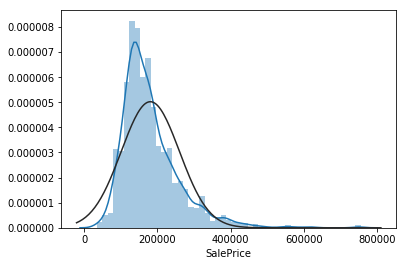

In [6]:
sns.distplot(df.SalePrice, fit=sp.stats.norm)

In [7]:
sp.stats.kurtosis(df.SalePrice)

6.509812011089439

((array([-3.30513952, -3.04793228, -2.90489705, ...,  2.90489705,
          3.04793228,  3.30513952]),
  array([ 34900,  35311,  37900, ..., 625000, 745000, 755000], dtype=int64)),
 (74160.164745194168, 180921.19589041095, 0.93196656415129864))

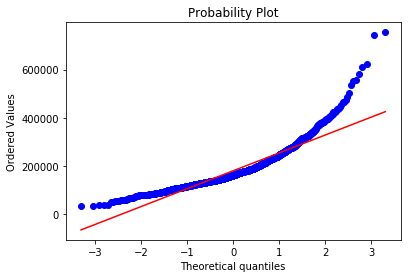

In [8]:
sp.stats.probplot(df.SalePrice, plot=plt)

График признака SalePrice выборки df сильно отличается от прямой, т.е. графика Q-Q нормального закона

((array([-3.30513952, -3.04793228, -2.90489705, ...,  2.90489705,
          3.04793228,  3.30513952]),
  array([-3.37022236, -3.27870743, -2.97300148, ...,  2.82944224,
          3.28907821,  3.48956068])),
 (1.0218203613548578, -0.017509537546313802, 0.99960673587220017))

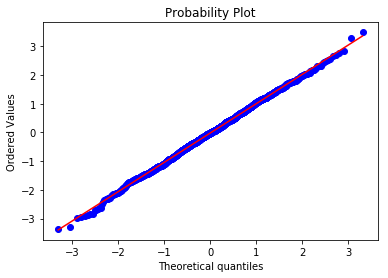

In [9]:
sp.stats.probplot(np.random.normal(size=df.SalePrice.shape), plot=plt)

## 1.2 Анализ некоторых зависимостей (3 балла)

У нас очень много разных признаков. Любопытно построить разные графики. Позаботьтесь о красоте и наглядности графиков, сделайте так, чтобы они были большие и их можно было прочесть. Даже подписи на графиках должны быть читаемые!!

Задания: Постройте графики, отражающие зависимости этих признаков:
- дата постройки дома и его стоимости
- "качество дома и материалов" и его стоимости
- площадь дома и стоимость

Hints: Вспомните про boxplot, jointplot, lmplot...

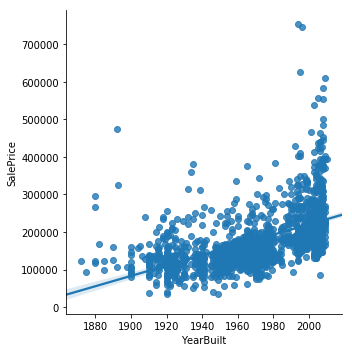

In [10]:
sns.lmplot(x='YearBuilt', y='SalePrice', data=df)

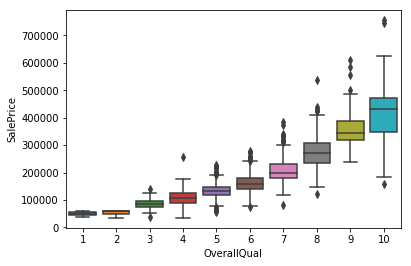

In [11]:
sns.boxplot(x="OverallQual", y="SalePrice", data=df)

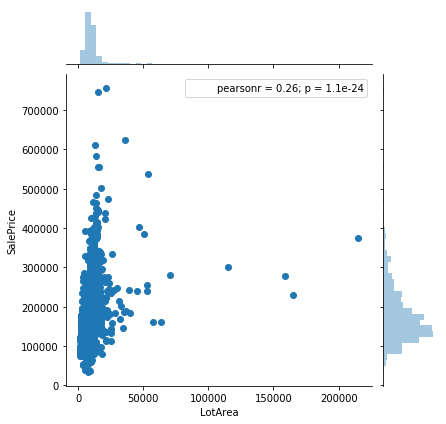

In [12]:
sns.jointplot(x="LotArea", y="SalePrice", data=df)

## 1.2 Heatmap (3 балла)

Судя по предыдущим графикам, есть некоторые линейные зависимости. Но строить по графику на каждый признак из 80 штук немного долго и не наглядно. Постройте красивый график корреляции всех признаков. Используйте цвета `RdYlGn`, так будет нагляднее. Не забудьте применить маску, чтобы убрать дублирующую половину матрицы.

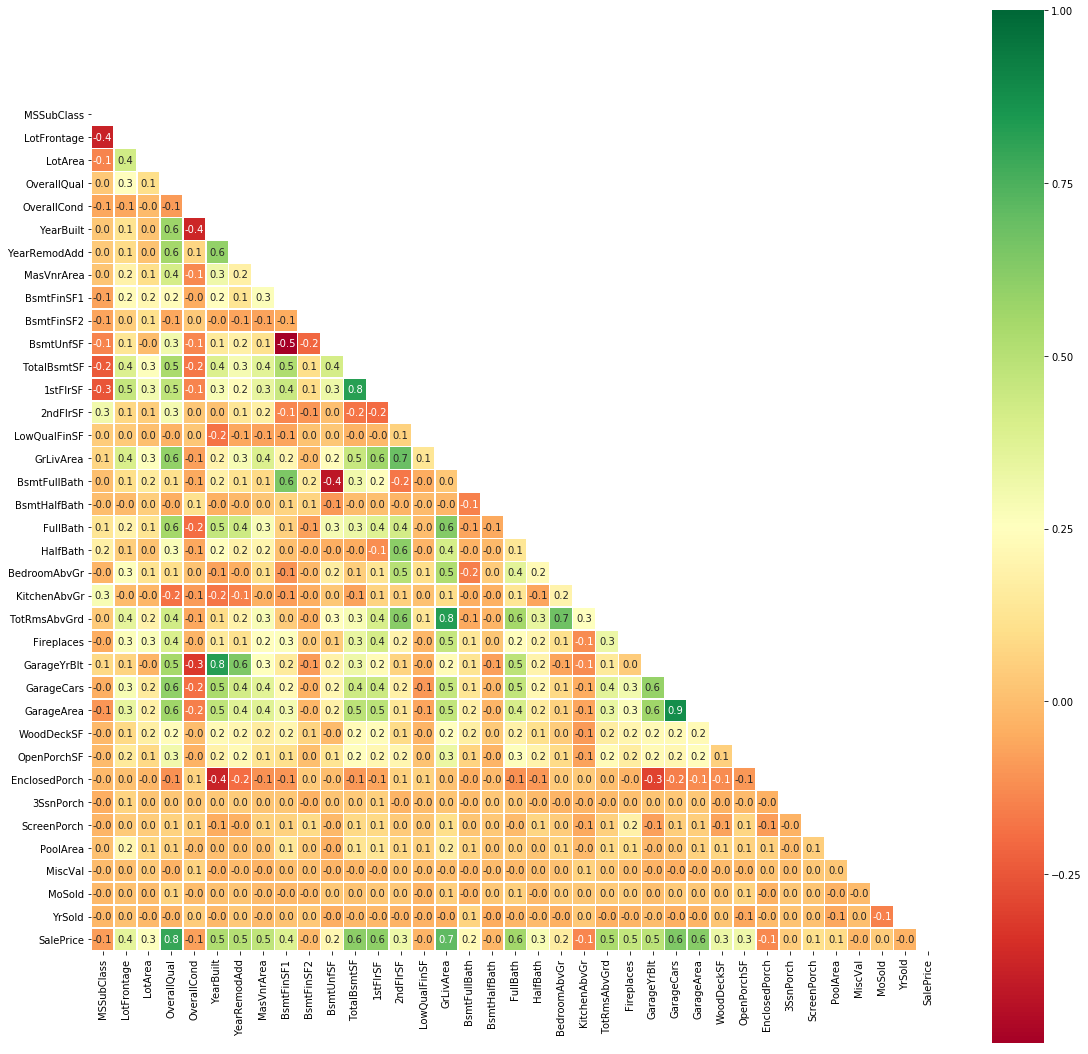

In [13]:
corr = df.corr()
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True
f, ax = plt.subplots(figsize=(19, 19))
sns.heatmap(corr, cmap="RdYlGn", square=True, linewidths=.5, mask=mask, annot=True, fmt=".1f")

Большая матрица 38x38 ячеек. И мы видим, там есть сильно коррелируемые объекты с нашей целевой переменной. 

- Нарисуйте крупно heatmap этих сильно коррелируемых объектов( больше 0.5 по абсолютному значению) и сделайте так, чтобы в каждой ячейке было значение корреляции. 
- Выведите список этих сильно коррелируемых признаков.

Запомним эти признаки!

In [14]:
corr1 = df.corr()[np.abs(df.corr()) > 0.5]

In [15]:
for x in corr1.columns:
    corr1[x][x] = np.nan

In [16]:
columns2drop = []
for x in corr1.columns:
    if corr1[x].isnull().all():
        columns2drop.append(x)

In [17]:
corr1 = corr1.drop(columns2drop).drop(columns2drop, axis=1)

In [18]:
corr1.shape

(17, 17)

In [19]:
mask = np.zeros_like(corr1, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

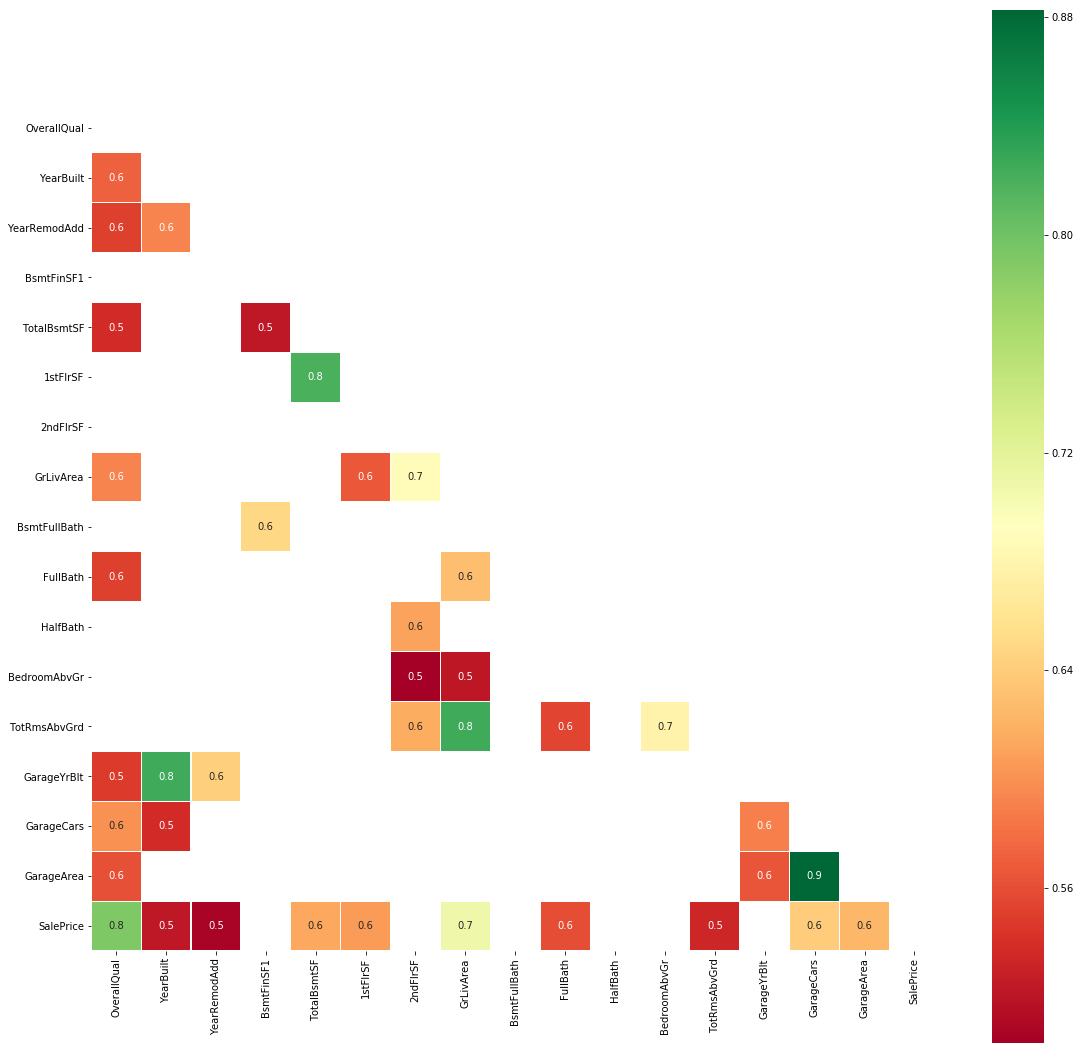

In [20]:
f, ax = plt.subplots(figsize=(19, 19))
sns.heatmap(corr1, cmap="RdYlGn", square=True, linewidths=.1, mask=mask, annot=True, fmt=".1f")

In [21]:
tmp = ~corr1.isnull().SalePrice

fs = tmp[tmp[~tmp.isnull()]].index

In [22]:
print(fs)

Index(['OverallQual', 'YearBuilt', 'YearRemodAdd', 'TotalBsmtSF', '1stFlrSF',
       'GrLivArea', 'FullBath', 'TotRmsAbvGrd', 'GarageCars', 'GarageArea'],
      dtype='object')


## 1.3 Пропущеные данные (3 балла)

Задание:
 - Посчитайте общее количество пропущенных данных по каждому признаку
 - посчитайте долю пропущенных данных выборки
 - удалите из выборки признаки, доля пропущенных которых больще 10%
 - пропущенные категориальные заполните словом 'unknown' (у них dtype object)
 - пропущенные числовые заполните средним (у них dtype float)

Hint: https://stackoverflow.com/a/38134049/3205200

In [23]:
# count of NaN data for every feature
len(df) - df.count()

MSSubClass          0
MSZoning            0
LotFrontage       259
LotArea             0
Street              0
Alley            1369
LotShape            0
LandContour         0
Utilities           0
LotConfig           0
LandSlope           0
Neighborhood        0
Condition1          0
Condition2          0
BldgType            0
HouseStyle          0
OverallQual         0
OverallCond         0
YearBuilt           0
YearRemodAdd        0
RoofStyle           0
RoofMatl            0
Exterior1st         0
Exterior2nd         0
MasVnrType          8
MasVnrArea          8
ExterQual           0
ExterCond           0
Foundation          0
BsmtQual           37
                 ... 
BedroomAbvGr        0
KitchenAbvGr        0
KitchenQual         0
TotRmsAbvGrd        0
Functional          0
Fireplaces          0
FireplaceQu       690
GarageType         81
GarageYrBlt        81
GarageFinish       81
GarageCars          0
GarageArea          0
GarageQual         81
GarageCond         81
PavedDrive

In [24]:
#dff = df.copy()

In [25]:
#df = dff.copy()

In [26]:
a = (len(df) - df.count())/len(df)

In [27]:
df = df.drop(labels=df.columns[a[df.columns] > 0.1], axis=1)

In [28]:
types = df.dtypes

In [29]:
b = len(df) - df.count()

In [30]:
b[b>0]

MasVnrType       8
MasVnrArea       8
BsmtQual        37
BsmtCond        37
BsmtExposure    38
BsmtFinType1    37
BsmtFinType2    38
Electrical       1
GarageType      81
GarageYrBlt     81
GarageFinish    81
GarageQual      81
GarageCond      81
dtype: int64

In [31]:
# pivot types
print(types['MasVnrArea'])
print(types['MSZoning'])

float64
object


In [32]:
df[df.columns[types == types['MasVnrArea']]].mean()

MasVnrArea      103.685262
GarageYrBlt    1978.506164
dtype: float64

In [33]:
df[df.columns[types == types['MasVnrArea']]] = df[df.columns[types == types['MasVnrArea']]].fillna(value=df[df.columns[types == types['MasVnrArea']]].mean())

In [34]:
df[df.columns[types == types['MSZoning']]] = df[df.columns[types == types['MSZoning']]].fillna(value='unknown')

In [35]:
#for c in df.columns:
#    if b[c] > 0:
#        if types[c] == types['MSZoning']:
#            df[c]=df[c].fillna('unknown')
#        elif types[c] == types['MasVnrArea']:
#            df[c]=df[c].fillna(np.mean(df[c]))

In [36]:
b = len(df) - df.count()

In [37]:
b[b > 0]

Series([], dtype: int64)

In [38]:
tmp = ~(df.corr()[np.abs(df.corr()) > 0.5]).isnull().SalePrice

fs = tmp[tmp[~tmp.isnull()]].index

In [39]:
print(fs)

Index(['OverallQual', 'YearBuilt', 'YearRemodAdd', 'TotalBsmtSF', '1stFlrSF',
       'GrLivArea', 'FullBath', 'TotRmsAbvGrd', 'GarageCars', 'GarageArea',
       'SalePrice'],
      dtype='object')


## 1.4 Категориальные переменные (1 балл)

На сколько вы помните, линейная регрессия не умеет обрабатывать категориальные признаки, так как ей нужны ЧИСЛА. Но не беда, в pandas есть встроенная функция [get_dummies](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.get_dummies.html).

Задание:
- сконвертируйте все категориальные признаки(dtype=object) в вектора числовых с помощью get_dummies
- напечатайте сколько у вас теперь признаков
- Положите в переменную X все данные из датасета, кроме целевой переменной. Положите в переменную y только целевую переменную.

In [40]:
dff = df[fs]

In [41]:
#data1 = pd.get_dummies(dff)

In [42]:
data = pd.get_dummies(df)

In [43]:
data.columns.shape

(281,)

In [44]:
X, y = data.drop(labels=['SalePrice'], axis=1), data.SalePrice

In [45]:
from sklearn.metrics import mean_squared_error

## 1.5 Переобучение (3 балла)

Обучим обычную модель без регуляризации [sklearn.linear_model.LinearRegression](http://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LinearRegression.html).

- Выведите все коэффициенты для каждого признака, отсортировав по возрастанию по модулю значения коэффициента. Используйте print и for, иначе jupyter схлопнет вывод numpy массива. Можете округлить коэффициенты до 2 знаков после запятой.
- Выведите **среднее** ошибки предсказания на 5 фолдах (cv=5) для этой линейной регрессии с помощью функции [sklearn.model_selection.cross_val_score](http://scikit-learn.org/stable/modules/generated/sklearn.model_selection.cross_val_score.html). Укажите `scoring='neg_mean_squared_error'`, чтобы считалась [MSE](http://scikit-learn.org/stable/modules/model_evaluation.html#mean-squared-error)

In [46]:
from sklearn.linear_model import LinearRegression as LR

model = LR(n_jobs=3)

%time model.fit(X, y)

Wall time: 255 ms


LinearRegression(copy_X=True, fit_intercept=True, n_jobs=3, normalize=False)

In [47]:
l = zip(model.coef_, X.columns)
%timeit for x in sorted(l, key=lambda item: -abs(item[0])): print(x)

(-608103.19741715433, 'RoofMatl_ClyTile')
(-193413.02377006982, 'Condition2_PosN')
(153235.70395639184, 'RoofMatl_Membran')
(124935.18130502234, 'RoofMatl_Metal')
(111029.7013575392, 'RoofMatl_WdShngl')
(95320.151839483995, 'GarageQual_Ex')
(-87958.307931489515, 'GarageCond_Ex')
(83342.886267671944, 'Condition2_PosA')
(-83080.398055145692, 'Condition2_RRAe')
(74872.586308132872, 'RoofStyle_Shed')
(63836.780889199908, 'RoofMatl_Tar&Grv')
(58413.13024458471, 'RoofMatl_CompShg')
(50567.619074365604, 'BsmtCond_Po')
(49880.689750957397, 'RoofMatl_WdShake')
(46772.009913374903, 'RoofMatl_Roll')
(45505.250663083789, 'Condition2_RRNn')
(44097.063442563369, 'Condition2_Artery')
(-42757.233539909255, 'Functional_Sev')
(-41058.629062443571, 'Electrical_Mix')
(40675.473424479642, 'Neighborhood_StoneBr')
(39995.00547117235, 'Condition2_Feedr')
(-38810.988547073408, 'GarageQual_Po')
(37507.10460803828, 'Condition2_Norm')
(-37000.498659733035, 'Exterior1st_ImStucc')
(-31176.738313219048, 'LandSlope_S

In [48]:
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold

In [49]:
kf = KFold(n_splits=5, shuffle=True, random_state=123)

In [50]:
model = LR(n_jobs=3)

In [51]:
%time np.mean(cross_val_score(model, X, y, cv=kf, n_jobs=3, scoring='neg_mean_squared_error'))

Wall time: 14.3 s


-1247261540.1621177

К счастью в этот раз коэффициенты при признаках не улетели в космос, но всё равно достигли очень больших значений. Например `RoofStyle_Shed` получился в моем случае около `-514961`. А у некоторых признаков коэффициент уже равен 0, хотя не была применена регуляризация.

## 1.6 Ridge и Lasso (4 балла)

- Обучите Lasso и Ridge для разных значений регуляризации alpha
- нарисуйте график значений коэффициентов модели для каждого признака, как мы делали на практике. По оси X будет значение alpha, по Y - значение коэффициента. на графике будет "радуга" из линий разных цветов(линий столько, сколько признаков).
- Нарисуйте гистограмму, в которой по оси Y будет количество коэффициентов, равных 0 (<0.0001) для Loss регресиии, а по оси X - значение коэффициента альфа.

alpha взять от 1 до 500 с каким-нибудь шагом. Но не переборщите, а то долго будете ждать.

In [52]:
from sklearn.linear_model import Lasso, Ridge

In [53]:
alphas = np.array([i*(10**j) for j in range(3) for i in range(1, 6)])
alphas

array([  1,   2,   3,   4,   5,  10,  20,  30,  40,  50, 100, 200, 300,
       400, 500])

In [54]:
from tqdm import tqdm_notebook, tqdm

In [55]:
%%time
coefs_lasso = np.zeros((alphas.shape[0], X.shape[1])) # матрица весов размера (число регрессоров) x (число признаков)
coefs_ridge = np.zeros((alphas.shape[0], X.shape[1]))

i = 0
for alpha in tqdm_notebook(alphas):
    lasso = Lasso(alpha=alpha, random_state=42)
    lasso.fit(X, y)
    coefs_lasso[i, :] = lasso.coef_
    
    ridge = Ridge(alpha=alpha, random_state=42)
    ridge.fit(X, y)
    coefs_ridge[i, :] = ridge.coef_
    
    i += 1

A Jupyter Widget

B:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)



Wall time: 27.5 s


280it [00:02, 123.35it/s]


Wall time: 3.19 s


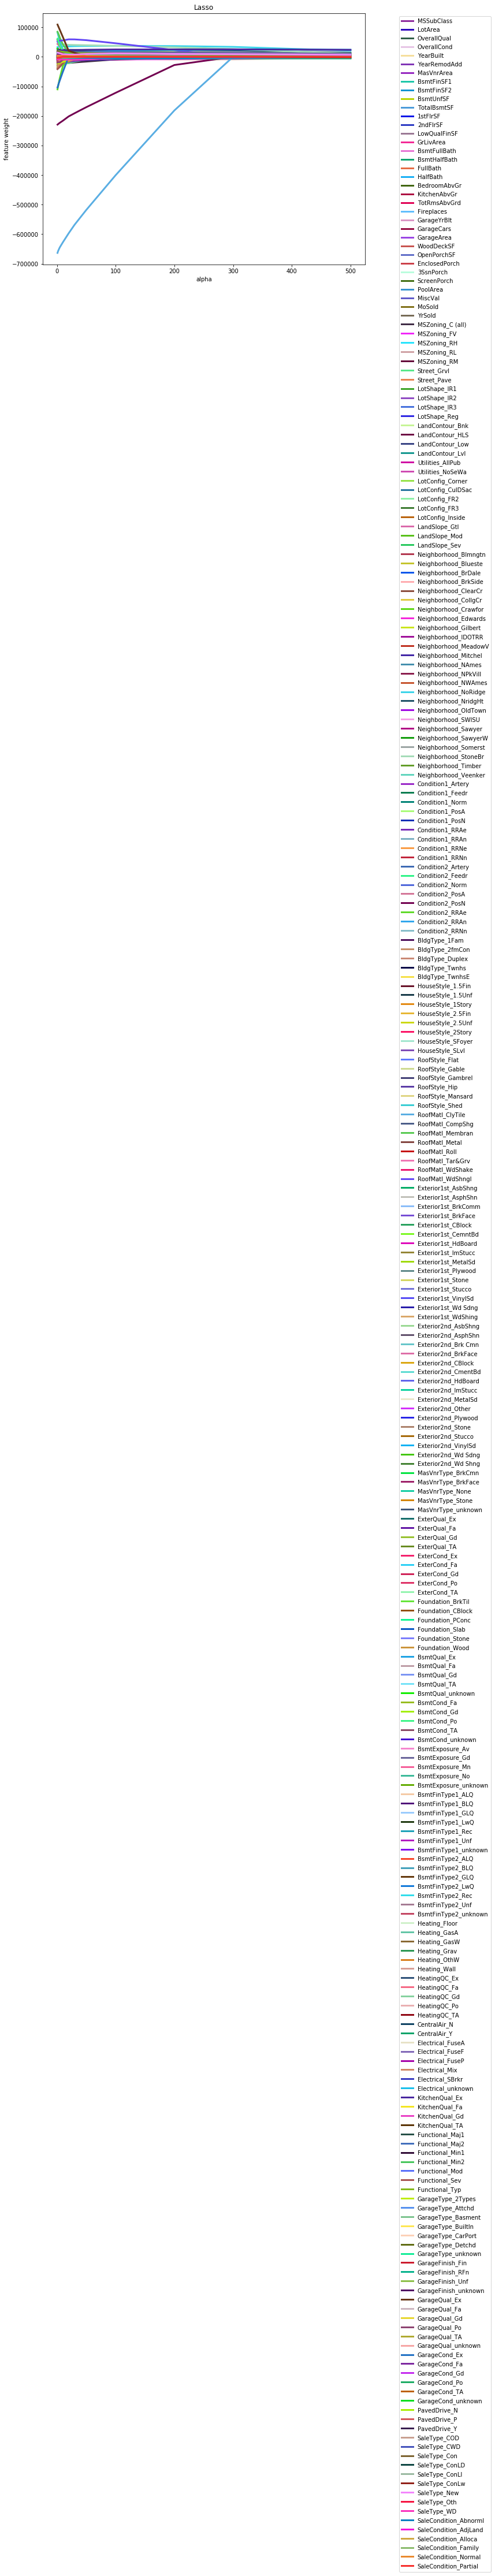

In [56]:
%%time
plt.figure(figsize=(10, 8))
for coef, feature in tqdm(zip(coefs_lasso.T, X.columns)):
    plt.plot(alphas, coef, label=feature, color=np.random.rand(3), linewidth=3)
plt.legend(loc="upper right", bbox_to_anchor=(1.4, 1))
plt.xlabel("alpha")
plt.ylabel("feature weight")
plt.title("Lasso")

280it [00:02, 95.92it/s]


Wall time: 4.06 s


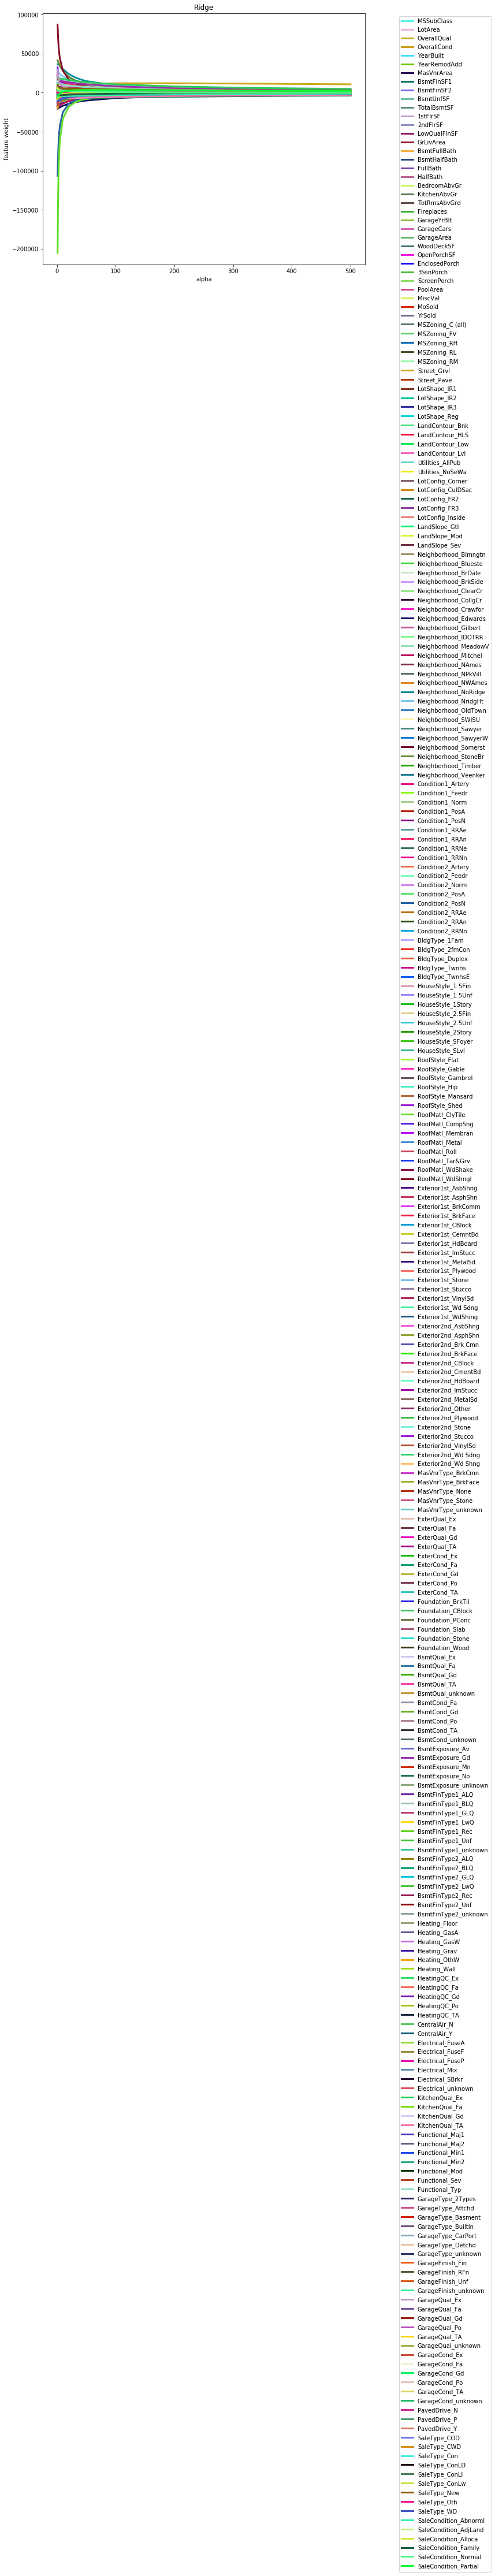

In [57]:
%%time
plt.figure(figsize=(10, 8))
for coef, feature in tqdm(zip(coefs_ridge.T, X.columns)):
    plt.plot(alphas, coef, label=feature, color=np.random.rand(3), linewidth=3)
plt.legend(loc="upper right", bbox_to_anchor=(1.4, 1))
plt.xlabel("alpha")
plt.ylabel("feature weight")
plt.title("Ridge")

In [58]:
eps = 1e-4

In [59]:
Ys = [(np.abs(x) < eps).sum() for x in coefs_lasso]

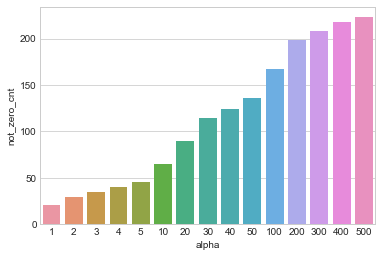

In [60]:
#plt.bar(alphas, Ys, align='center')
sns.set_style("whitegrid")
dt = pd.DataFrame(data = {'alpha': alphas, 'not_zero_cnt': Ys})
sns.barplot(x="alpha", y="not_zero_cnt", data=dt)

## 1.7 Поиск оптимального alpha (6 баллов)

- С помощью метода LassoCV найдите оптимальное значение alpha и напечатайте его, используя разбиение на 5 фолда в кроссвалидации (`cv=5`).
- Нарисуйте график зависимости MSE от alpha (`mse_path_`).
- Нарисуйте длинную гистограмму магнитуда признаков, как в классе, на которой будет показано значение коэффициента для каждого признака. Графк должен быть остортирован по величине коэффициентов. Признаки с нулевыми коэффициентами должны быть удалены.
- Сколько в итоге ненулевых признаков осталось?
- Выведите **среднее** ошибки предсказания на 5 фолдах (cv=5) для этой линейной регрессии с помощью функции [sklearn.model_selection.cross_val_score](http://scikit-learn.org/stable/modules/generated/sklearn.model_selection.cross_val_score.html). Укажите `scoring='neg_mean_squared_error'`, чтобы считалась [MSE](http://scikit-learn.org/stable/modules/model_evaluation.html#mean-squared-error). Качество должно быть лучше, чем у простой линейной регрессии.

In [61]:
from sklearn.linear_model import LassoCV

B:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


Wall time: 5.45 s
optimal alpha = 200


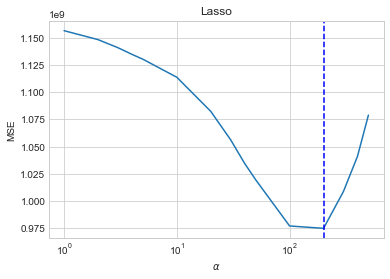

In [62]:
lassocv = LassoCV(n_jobs=3, alphas=alphas, random_state=42, cv=5)

%time lassocv.fit(X, y)
lassocv_alpha = lassocv.alpha_
print('optimal alpha =', lassocv_alpha)

mean_mse = np.mean(lassocv.mse_path_, axis=1)

plt.plot(lassocv.alphas_, mean_mse)

plt.title('Lasso')
plt.ylabel('MSE')
plt.xlabel(r'$\alpha$')
plt.axvline(lassocv_alpha, color='b', ls='--')
plt.xscale('log')

In [63]:
%time f2c = sorted(list(zip(X.columns.copy(), lassocv.coef_.copy())), key=lambda item: -abs(item[1]))

Wall time: 1 ms


In [64]:
%%time
n = len(f2c)
for i in range(n - 1, -1, -1):
    if abs(f2c[i][1]) < eps:
        f2c.pop(i)

Wall time: 1 ms


In [65]:
# count of non-zero coefficients for features
len(f2c)

82

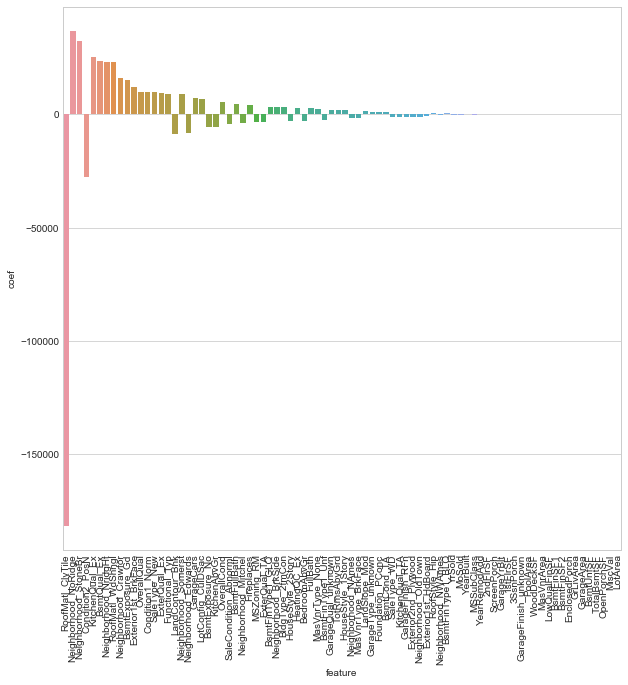

In [66]:
plt.figure(figsize=(10, 10))
sns.set_style("whitegrid")
dt = pd.DataFrame(data = {'feature': [x[0] for x in f2c], 'coef': [x[1] for x in f2c]})
gr= sns.barplot(x="feature", y="coef", data=dt)
gr.set_xticklabels(gr.get_xticklabels(), rotation=90, fontdict={'fontsize': 10})
gr

In [67]:
lassocv = LassoCV(n_jobs=3, alphas=alphas, random_state=42, cv=5)

In [68]:
%time np.mean(cross_val_score(lassocv, X, y, cv=kf, n_jobs=3, scoring='neg_mean_squared_error'))

Wall time: 29.3 s


-1093591119.7909312

## 1.8 Предсказание на отложенной выборке (3 балла)

- Используя [sklearn.model_selection.train_test_split](http://scikit-learn.org/stable/modules/generated/sklearn.model_selection.train_test_split.html) разбейте датасет на 2 части - тренировочную и тестовую в соотношении 0.33. Не забудьте перемешать!
- Напечатайте размерность X_train и X_test

In [69]:
from sklearn.model_selection import train_test_split

In [70]:
X_train, X_test, y_train, y_test = train_test_split(X, y, shuffle=True, random_state=123, test_size=0.33)

In [71]:
print("X_train.shape =", X_train.shape)
print("X_test.shape =", X_test.shape)

X_train.shape = (978, 280)
X_test.shape = (482, 280)


Теперь, возьмите вашу самую мощную модель(не тренированную!). Запустите её тренировку по тренировочной выборке X_train, y_train с помощью функции `fit`. Постройте предсказания с помощью функции `predict`.

In [72]:
lassocv = LassoCV(n_jobs=3, alphas=alphas, random_state=42, cv=5)

In [73]:
%time np.mean(cross_val_score(lassocv, X, y, cv=kf, n_jobs=3, scoring='neg_mean_squared_error'))

Wall time: 30.3 s


-1093591119.7909312

In [74]:
lassocv = LassoCV(n_jobs=3, alphas=alphas, random_state=42, cv=5)
lassocv.fit(X_train, y_train)

B:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


LassoCV(alphas=array([  1,   2,   3,   4,   5,  10,  20,  30,  40,  50, 100, 200, 300,
       400, 500]),
    copy_X=True, cv=5, eps=0.001, fit_intercept=True, max_iter=1000,
    n_alphas=100, n_jobs=3, normalize=False, positive=False,
    precompute='auto', random_state=42, selection='cyclic', tol=0.0001,
    verbose=False)

In [75]:
y_pred = lassocv.predict(X_test)

Визуализируйте scatter plot предсказанных значений и настоящих (`y_test`). У вас должен получиться график, точки которого расположены приблизительно вдоль некоторой прямой с разбросом. Идеальный предсказатель будет выглядить как набор точек вдоль прямой без разброса.

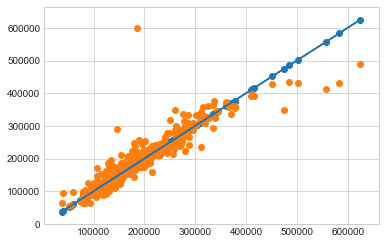

In [76]:
plt.plot(y_test, y_test)
plt.scatter(y_test, y_test)
plt.scatter(y_test, y_pred)

In [77]:
mse = mean_squared_error(y_test, y_pred)
print("MSE =", mse)

MSE = 971223807.906


## 1.9 Ограниченная версия ( 4 балла)

Помните в самом начале мы оставили очень мало признаков по данным из heatmap. Настало время проверить как он себя покажет! К счастью они все сразу числовые, а не категориальные. Переиспользуйте тот дадасет, где вы уже поборолись с пропусками.
Снова выделите отдельно X и y и запустите кроссвалидацию c 5 фолдами по Lasso с `alpha=1`.

In [78]:
dff = df[fs]

In [79]:
XX, yy = dff.drop(labels=["SalePrice"], axis=1), dff.SalePrice

In [80]:
lasso = Lasso(alpha=1, random_state=42)

In [81]:
%time np.mean(cross_val_score(lasso, X, y, cv=kf, n_jobs=3, scoring='neg_mean_squared_error'))

Wall time: 15.4 s


-1206715130.7247381

In [82]:
X_train, X_test, y_train, y_test = train_test_split(XX, yy, shuffle=True, random_state=123, test_size=0.33)

In [83]:
%%time
lasso = Lasso(alpha=1, random_state=42)
lasso.fit(X_train, y_train)

Wall time: 13 ms


In [84]:
y_pred = lasso.predict(X_test)

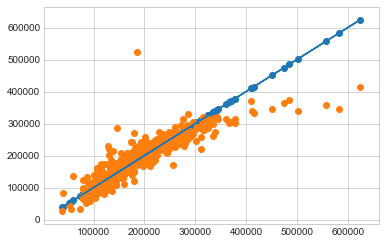

In [85]:
plt.plot(y_test, y_test)
plt.scatter(y_test, y_test)
plt.scatter(y_test, y_pred)

In [86]:
mse = mean_squared_error(y_test, y_pred)
print("MSE =", mse)

MSE = 1404546053.51


Попробуем LassoCV!

In [ ]:
lassocv = LassoCV(n_jobs=3, alphas=alphas, random_state=42, cv=5)

In [ ]:
%time np.mean(cross_val_score(lasso, X, y, cv=kf, n_jobs=3, scoring='neg_mean_squared_error'))

In [ ]:
%%time
lassocv = LassoCV(n_jobs=3, alphas=alphas, random_state=42, cv=5)
lassocv.fit(X_train, y_train)

In [ ]:
y_pred = lassocv.predict(X_test)

In [ ]:
plt.plot(y_test, y_test)
plt.scatter(y_test, y_test)
plt.scatter(y_test, y_pred)

In [ ]:
mse = mean_squared_error(y_test, y_pred)
print("MSE =", mse)

Можете посмотреть еще много разных примеров обработки этого датасета тут: https://www.kaggle.com/c/house-prices-advanced-regression-techniques/kernels

А суть всего этого такова, что в итоге надо кучу времени потратить на подготовку признаков. Смотреть на кучу графиков а потом стакать модели.